Hm0 (Welch) = 3.04 m
Tp  (Welch) = 8.00 s  (fp = 0.125 Hz)
Tm01 = 6.79 s,  Tm02 = 6.36 s


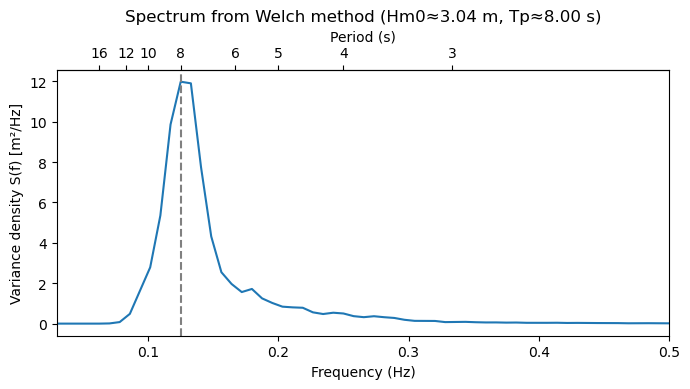

<Figure size 640x480 with 0 Axes>

In [1]:
import numpy as np
from scipy import signal, integrate
import matplotlib.pyplot as plt
import pandas as pd

# load  time series
df = pd.read_csv("synthetic_ssh_Hmo_3.01_Tp_8.0.csv")
time_s = df["time_s"].to_numpy()
eta_m  = df["eta_m"].to_numpy()

fs = 4.0  # Hz (sampling rate)

# --- Welch parameters (sensible defaults for 20 min @ 4 Hz; N = 4800)
nperseg  = 512            # segment length
noverlap = nperseg // 2    # 50% overlap
window   = "hann"          # standard Hann window

# Welch returns one-sided PSD (for real signals), units: m^2/Hz for elevation
f, S_welch = signal.welch(
    eta_m,
    fs=fs,
    window=window,
    nperseg=nperseg,
    noverlap=noverlap,
    detrend="constant",
    return_onesided=True,
    scaling="density",
    average="mean"
)

# --- Spectral moments and bulk parameters
m0   = integrate.trapezoid(S_welch, f)     # zeroth moment = variance
Hm0  = 4.0 * np.sqrt(m0)                   # significant height (spectral)
fp   = f[np.argmax(S_welch)]               # peak frequency (Hz)
Tp   = 1.0 / fp if fp > 0 else np.nan      # peak period (s)

print(f"Hm0 (Welch) = {Hm0:.2f} m")
print(f"Tp  (Welch) = {Tp:.2f} s  (fp = {fp:.3f} Hz)")

# --- Optional: other period definitions from moments
m1   = integrate.trapezoid(f * S_welch, f)
m2   = integrate.trapezoid((f**2) * S_welch, f)
Tm01 = m0 / m1            # mean period (m0/m1)
Tm02 = np.sqrt(m0 / m2)   # mean zero-crossing period

print(f"Tm01 = {Tm01:.2f} s,  Tm02 = {Tm02:.2f} s")

fig, ax = plt.subplots(figsize=(7,4))

# bottom axis: frequency
ax.plot(f, S_welch, )
ax.set_xlim(0.03, 0.50)            # avoid f=0 so the transform T=1/f stays finite
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Variance density S(f) [m²/Hz]")
ax.set_title(f"Spectrum from Welch method (Hm0≈{Hm0:.2f} m, Tp≈{Tp:.2f} s)")
ax.axvline(fp, ls="--", color="gray")

# top axis: period, using an exact transform
def f_to_T(fvals):
    return 1.0/np.clip(fvals, 1e-12, None)

def T_to_f(Tvals):
    return 1.0/np.clip(Tvals, 1e-12, None)

secax = ax.secondary_xaxis('top', functions=(f_to_T, T_to_f))
secax.set_xlabel("Period (s)")

# choose clean period ticks within your frequency window (0.03–0.50 Hz → ~2–33 s)
T_ticks = [3, 4, 5, 6, 8, 10, 12, 16]
secax.set_xticks(T_ticks)
plt.tight_layout()
plt.show()
plt.savefig('loglog_welch_method_spectrum.png')

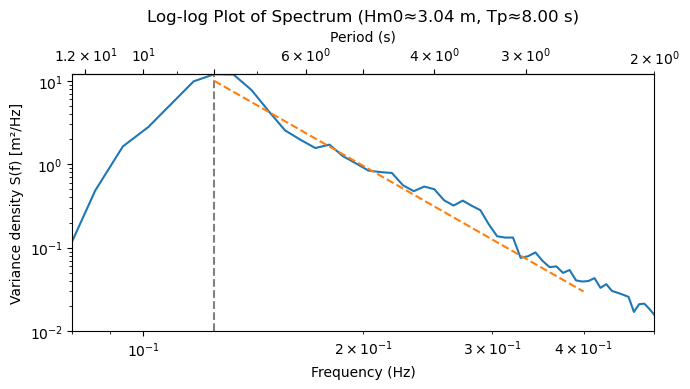

<Figure size 640x480 with 0 Axes>

In [2]:
fig, ax = plt.subplots(figsize=(7,4))
ax.loglog(f, S_welch)
ax.set_xlim(0.08, 0.50)
ax.set_ylim(.01, 12)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Variance density S(f) [m²/Hz]")
ax.set_title(f"Log-log Plot of Spectrum (Hm0≈{Hm0:.2f} m, Tp≈{Tp:.2f} s)")
ax.axvline(fp, ls="--", color="gray")

fline = np.linspace( 1/Tp, 0.4 )
sline = 10*(fline*Tp)**(-5)
ax.loglog( fline, sline, '--')
# top axis: period, using an exact transform
def f_to_T(fvals):
    return 1.0/np.clip(fvals, 1e-12, None)

def T_to_f(Tvals):
    return 1.0/np.clip(Tvals, 1e-12, None)

secax = ax.secondary_xaxis('top', functions=(f_to_T, T_to_f))
secax.set_xlabel("Period (s)")

# choose clean period ticks within your frequency window (0.03–0.50 Hz → ~2–33 s)
T_ticks = [3, 4, 5, 6, 8, 10, 12, 16]
secax.set_xticks(T_ticks)

plt.tight_layout()
plt.show()
plt.savefig('loglog_welch_method_spectrum.png')

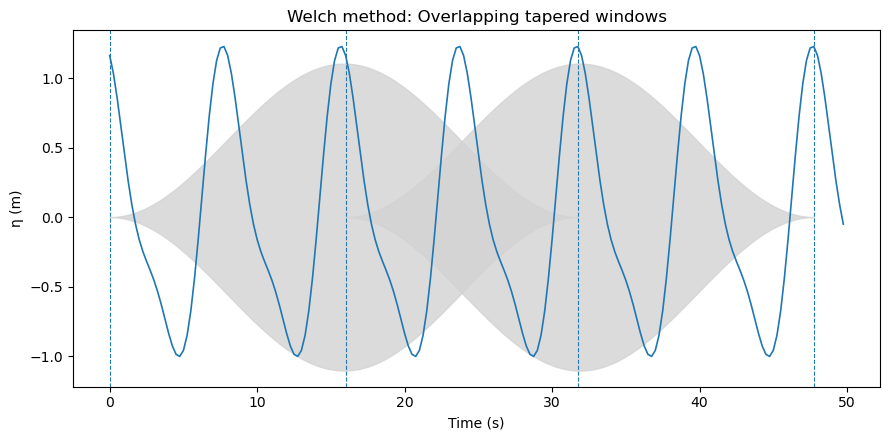

In [3]:
# Make a figure to demo the Hanning windows

fs = 4.0
t = np.arange(0, 50, 1/fs)
eta = np.cos(2*np.pi*(1/8.0)*t) + 0.3*np.cos(2*np.pi*(1/4.0)*t + 1.0)

nperseg = 128
hop = nperseg // 2
win = np.hanning(nperseg)

# Time series slice already 50 s long at 4 Hz -> 200 samples
# Overlay windows
yscale = 0.9 * np.max(np.abs(eta))
k_starts = [0, hop, 2*hop]
k_starts = [k for k in k_starts if k + nperseg <= len(t)]

plt.figure(figsize=(9,4.5))
plt.plot(t, eta, linewidth=1.2)

for ks in k_starts:
    tt = t[ks:ks+nperseg]
    env = yscale * win
    plt.fill_between(tt, env, -env, color='lightgray', alpha=0.8)

for ks in k_starts:
    plt.axvline(t[ks], linestyle="--", linewidth=0.8)
    plt.axvline(t[ks + nperseg - 1], linestyle="--", linewidth=0.8)

plt.xlabel("Time (s)")
plt.ylabel("η (m)")
plt.title("Welch method: Overlapping tapered windows")
plt.tight_layout()
plt.show()
